In [1636]:
import numpy as np
import pandas as pd
from math import isnan
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
import scipy as sp
import scipy.stats
import random

In [1637]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
hiae = pd.read_csv("data/hiae.csv")
hmvsc = pd.read_csv("data/hmvsc.csv")

## Data prep

In [1638]:
# Valid variable thresholds
thresholds = {
    'highest_respiratory_rate1h': [1, 80],
    'highest_temperature1h': [25, 46],
    'highest_heart_rate1h': [20, 220],
    'lowest_mean_arterial_pressure1h': [1, 200],
    'lowest_diastolic_blood_pressure1h': [1, 200],
    'lowest_systolic_blood_pressure1h': [1, 300],
    'bmi': [10, 70]
}

In [1639]:
normal = {
    'highest_respiratory_rate1h': 16,
    'highest_temperature1h': 37,
    'highest_heart_rate1h': 80,
    'lowest_mean_arterial_pressure1h': 90,
    'lowest_diastolic_blood_pressure1h': 80,
    'lowest_systolic_blood_pressure1h': 120,
    'lengthhospitalstaypriorunitadmission': 0
}

In [1640]:
# Function to remove invalid thresholds
def remove_invalid(df, thresholds):
    for c in thresholds:
        df.loc[(df[c] < thresholds[c][0]) | (df[c] > thresholds[c][1]), c] = np.nan

In [1641]:
# Remove invalid thresholds
remove_invalid(hiae, thresholds)
remove_invalid(hmvsc, thresholds)

In [1642]:
# Group glasgow
def group_gcs(gcs):
    if isnan(gcs):
        return np.nan
    
    gcs = int(gcs)
    if gcs < 15:
        return 1
    elif gcs == 15:
        return 2

In [1643]:
def group_adm_src(df):
     df['admissionsourcename'].replace({
         'Enfermaria / quarto': 'floor',
         'Centro Cirúrgico': 'operating room',
         'Sala de hemodinâmica': 'operating room',
         'Emergência': 'emergency room',
         'Home-care': 'emergency room', 
         'Transferência de outro hospital/instituição': 'other sources',
         'Outra UTI/UCI do seu hospital': 'other icu',
         'Unidade Semi-intensiva': 'other sources',
         'Outra - Não especificada': 'other sources'
     }, inplace=True)

In [1644]:
# Group gcs
hiae['glasgow'] = hiae['lowest_glasgow_coma_scale1h'].apply(group_gcs)
hmvsc['glasgow'] = hmvsc['lowest_glasgow_coma_scale1h'].apply(group_gcs)

# Group admission source
group_adm_src(hiae)
group_adm_src(hmvsc)

In [1645]:
class CustomImputer:
    def __init__(self, normal, c_cols):
        self.normal = normal
        self.c_cols = c_cols

    def fit(self, X, y=None):
        self.modes = [(c, X[c].dropna().mode()[0]) for c in self.c_cols]
        return self

    def transform(self, X):
        output = X.copy()
        for c, v in self.normal.items():
            output[c].fillna(v, inplace=True)
        for c, v in self.modes:
            output[c].fillna(v, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [1646]:
class CustomLabelEncoder:
    def __init__(self, values):
        self.values = values

    def fit(self, X, y=None):
        self.encoders = [(c, LabelEncoder().fit(v)) for c, v in self.values]
        return self

    def transform(self, X):
        output = X.copy()
        for c, e in self.encoders:
            output.loc[output[c].notna(), c] = e.transform(output.loc[output[c].notna(), c])
            output[c].fillna(-1, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [1647]:
class OneHotEncoder:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        output = X.copy()
        output = pd.get_dummies(output, columns=self.columns, drop_first=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [1648]:
class CustomScaler:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        self.scalers = [(c, StandardScaler().fit(X[c].astype(float).values.reshape(-1,1))) for c in self.columns]
        return self

    def transform(self, X):
        output = X.copy()
        for c, s in self.scalers:
            output[c] = s.transform(output[c].astype(float).values.reshape(-1,1))
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [1649]:
# Lists of variable types
target = "hospitalexpireflag"

#pre icu
demographic = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name",
               "age", "lengthhospitalstaypriorunitadmission", "bmi_group"]

#lab results
physiological = ["lowest_systolic_blood_pressure1h", "lowest_diastolic_blood_pressure1h",
                 "lowest_mean_arterial_pressure1h", "highest_heart_rate1h", "highest_respiratory_rate1h",
                 "highest_temperature1h"]

glasgow = ["glasgow"]
                 
c_cols_og = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name", 
          "glasgow", "bmi_group"]

n_cols_og = ["age", "lowest_systolic_blood_pressure1h", 
          "lowest_diastolic_blood_pressure1h","lowest_mean_arterial_pressure1h", "highest_heart_rate1h", 
          "highest_respiratory_rate1h", "highest_temperature1h", "lengthhospitalstaypriorunitadmission"]

### Helper Functions To Run The Models

In [1675]:
def predict_probs(pipeline, X_hiae, y_hiae, X_hmvsc, y_hmvsc):
    
    # HIAE, Run model
    y_pred_hiae = cross_val_predict(pipeline, X_hiae, y_hiae, cv=5, method='predict_proba')

    # Numpy array of probs
    y_true_hiae = np.array(y_hiae)
    y_pred_hiae = np.array(y_pred_hiae)

    # HMVSC, Run model
    model = pipeline.fit(X_hiae, y_hiae)

    # Predict probs
    y_true_hmvsc = np.array(y_hmvsc)
    y_pred_hmvsc = np.array(pipeline.predict_proba(X_hmvsc))
    
    # Get mortality rates
    mort_hiae = sum(y_true_hiae)/y_true_hiae.size
    X_rec_hiae = pd.DataFrame(y_pred_hiae[:,1])
    X_rec_hiae["mort"] = mort_hiae
    
    mort_hmvsc = sum(y_true_hmvsc)/y_true_hmvsc.size
    X_rec_hmvsc = pd.DataFrame(y_pred_hmvsc[:,1])
    X_rec_hmvsc["mort"] = mort_hmvsc
    
    run_model(pipeline, X_rec_hiae, y_hiae, X_rec_hmvsc, y_hmvsc)

In [1676]:
def run_model(pipeline, X_rec_hiae, y_hiae, X_rec_hmvsc, y_hmvsc):
    
    y_rec_hiae = y_hiae.copy()
    y_rec_hmvsc = y_hmvsc.copy()
    
    # Split
    X_train_hiae, X_test_hiae, y_train_hiae, y_test_hiae = train_test_split(X_rec_hiae, y_rec_hiae, 
                                                        test_size=y_rec_hiae.size-600
                                                                            , stratify=y_rec_hiae, random_state=42)
    
    X_train_hmvsc, X_test_hmvsc, y_train_hmvsc, y_test_hmvsc = train_test_split(X_rec_hmvsc, y_rec_hmvsc, 
                                                        test_size=y_rec_hmvsc.size-600
                                                                            , stratify=y_rec_hmvsc, random_state=42)
    X_train = X_train_hmvsc.append(X_train_hiae)
    y_train = y_train_hmvsc.append(y_train_hiae)
    
    # Run models
    rec = LogisticRegression(class_weight={0:1.9,1:1.7})
    rec.fit(X_train, y_train)

    # Predict probs
    y_true_hmvsc = y_test_hmvsc
    y_pred_hmvsc = rec.predict_proba(X_test_hmvsc)[:,1]
    
    y_true_hiae = y_test_hiae
    y_pred_hiae = rec.predict_proba(X_test_hiae)[:,1]
    
    # Calculate SMR values for both
    print(sum(y_true_hiae)/sum(y_pred_hiae), 'SMR HIAE')
    print(sum(y_true_hmvsc)/sum(y_pred_hmvsc), 'SMR HMVSC')
    
    # Plot the data
    plot(y_pred_hiae, y_true_hiae, y_pred_hmvsc, y_true_hmvsc)

In [1677]:
def plot(y_pred_hiae, y_true_hiae, y_pred_hmvsc, y_true_hmvsc):
    # Metrics Logit

    # Perfectly calibrated curve
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    # Define number of bins
    n_bins = 10

    # HIAE metrics
    print(roc_auc_score(y_true_hiae, y_pred_hiae), "AUC HIAE")

    fraction_of_positives, mean_predicted_value = calibration_curve(y_true_hiae, y_pred_hiae, n_bins=n_bins)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="HIAE")
    
    # HMVSC metrics
    auc_hmvsc = roc_auc_score(y_true_hmvsc, y_pred_hmvsc)
    print(auc_hmvsc, "AUC HMVSC")
    
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true_hmvsc, y_pred_hmvsc, n_bins=n_bins)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="HMVSC")
    
    #Calculate CI for both
    print(mean_confidence_interval(y_pred_hiae+y_true_hiae), 'CI HIAE')
    print(mean_confidence_interval(y_pred_hmvsc+y_true_hmvsc), 'CI HMVSC')

    # Plot calibration
    plt.legend()
    plt.show()

In [1678]:
def columns(block):
    if block == 1:
        columns = physiological
    elif block == 2:
        columns = demographic
    elif block == 3:
        columns = physiological + demographic
    elif block == 4:
        columns = physiological + demographic + glasgow
    return columns

In [1679]:
def mean_confidence_interval(data, confidence=0.95):
    '''Confidence Interval calculator'''
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m-h, m+h

## Logit trained in HIAE data

In [1680]:
def lg(hiae, hmvsc, columns, target):
    
    # Seperate x and y values
    X_hiae = hiae[columns].copy()
    X_hmvsc = hmvsc[columns].copy()
    
    y_hiae = hiae[target].copy()
    y_hmvsc = hmvsc[target].copy()    
    
    # Create null flag column
    for c in X_hiae.columns:
        X_hiae[c+"_null"] = X_hiae[c].isna().astype(int)
        X_hmvsc[c+"_null"] = X_hmvsc[c].isna().astype(int)

    # Get unique values for categorical features, after filtering the columns according to each block
    c_cols = [c for c in c_cols_og if c in X_hiae.columns]
    n_cols = [n for n in n_cols_og if n in X_hiae.columns]

    values = [(c, X_hiae.append(X_hmvsc).dropna()[c].unique()) for c in c_cols]

    # Model
    logr = LogisticRegression(solver='liblinear', penalty='l1')

    #Normal values filtered for each block
    filtered_normal = {}
    for key in normal.keys():
        if key in n_cols: filtered_normal[key] = normal[key]
    
    # Create pipeline
    pipe_logr = Pipeline([
        ("imputer", CustomImputer(filtered_normal, c_cols)),
        ("encoder", CustomLabelEncoder(values)),
        ("ohe", OneHotEncoder(c_cols)),
        ("scaler", CustomScaler(n_cols)),
        ("model", logr)])
    
    predict_probs(pipe_logr, X_hiae, y_hiae, X_hmvsc, y_hmvsc)

0.7855751187361246 SMR HIAE
1.3069097609636133 SMR HMVSC
0.6629577554722821 AUC HIAE
0.6696981469708743 AUC HMVSC
(0.18371402235137352, 0.19850714478273518) CI HIAE
(0.3068939131359924, 0.3550425006861096) CI HMVSC


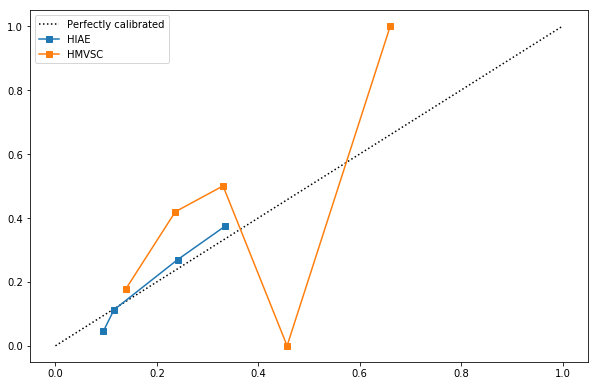

0.7540611425625233 SMR HIAE
1.29736961738946 SMR HMVSC
0.7777445295959594 AUC HIAE
0.7435573685573685 AUC HMVSC
(0.18752370255791764, 0.20364355429369155) CI HIAE
(0.30704611396369536, 0.3570002726432045) CI HMVSC


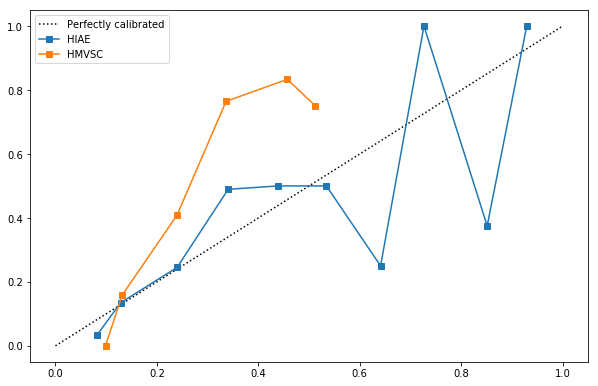

0.7453204638869497 SMR HIAE
1.2690494969351884 SMR HMVSC
0.8102111704709403 AUC HIAE
0.7783046078500625 AUC HMVSC
(0.1884927234684605, 0.2052898235208778) CI HIAE
(0.3091634823039572, 0.36133326617247485) CI HMVSC


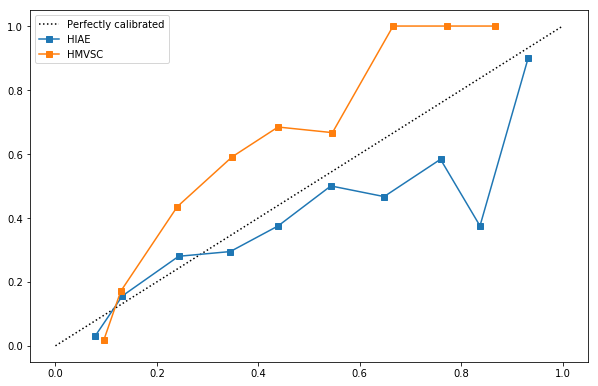

0.7622270772538129 SMR HIAE
1.254837135662468 SMR HMVSC
0.8340826694478284 AUC HIAE
0.8308875467966377 AUC HMVSC
(0.1855772227694587, 0.20320090675204222) CI HIAE
(0.3088550233266565, 0.36498853919034335) CI HMVSC


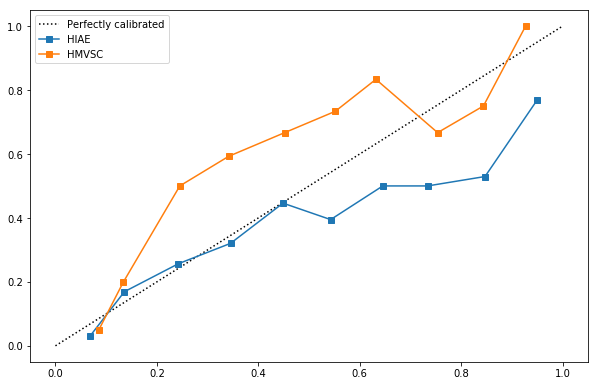

In [1681]:
'''Run the model on each of the four blocks'''
for block in range(1,5):    
    lg(hiae.copy(), hmvsc.copy(), columns(block), target)

## XGBoost trained in HIAE data

In [1657]:
# Get unique values for categorical features
def xgboost(hiae, hmvsc, columns, target):
    
    #Get x and y values
    X_hiae = hiae[columns].copy()
    X_hmvsc = hmvsc[columns].copy()
    
    y_hiae = hiae[target].copy()
    y_hmvsc = hmvsc[target].copy() 
    
    
    #Filter the columns according to each block and get unique values
    c_cols = [c for c in c_cols_og if c in X_hiae.columns]
    n_cols = [n for n in n_cols_og if n in X_hiae.columns]
  
    values = [(c, X_hiae.append(X_hmvsc).dropna()[c].unique()) for c in c_cols]

    # Model
    xbst = XGBClassifier(n_estimators=100, max_depth=2)

    # Create pipeline
    pipe_xbst = Pipeline([
        ("lenc", CustomLabelEncoder(values)),
        ("model", xbst)
    ])
    
    predict_probs(pipe_xbst, X_hiae, y_hiae, X_hmvsc, y_hmvsc)

0.790072497498319 SMR HIAE
1.309379705289102 SMR HMVSC
0.6694538798332805 AUC HIAE
0.6666990416990417 AUC HMVSC
(0.18310337067130145, 0.19789928637436072) CI HIAE
(0.30661265519143477, 0.3547824970208894) CI HMVSC


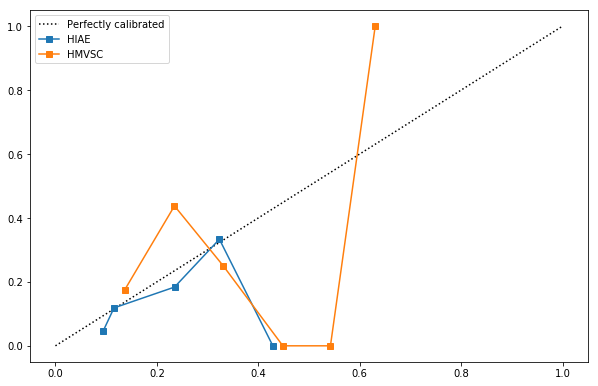

0.7466760798839743 SMR HIAE
1.3329860021217548 SMR HMVSC
0.785150457760689 AUC HIAE
0.7330708012526195 AUC HMVSC
(0.1887886327213113, 0.20458428995198658) CI HIAE
(0.3036801168298095, 0.3526431674380682) CI HMVSC


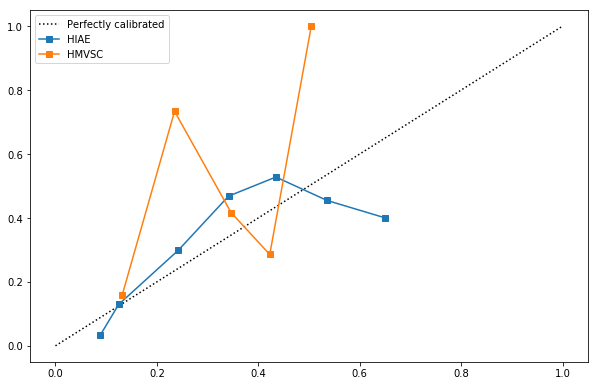

0.7280737363578423 SMR HIAE
1.323909575697892 SMR HMVSC
0.8107833452484244 AUC HIAE
0.7775334934425844 AUC HMVSC
(0.191267156765059, 0.2078599583833468) CI HIAE
(0.3039502485967259, 0.3543017248640148) CI HMVSC


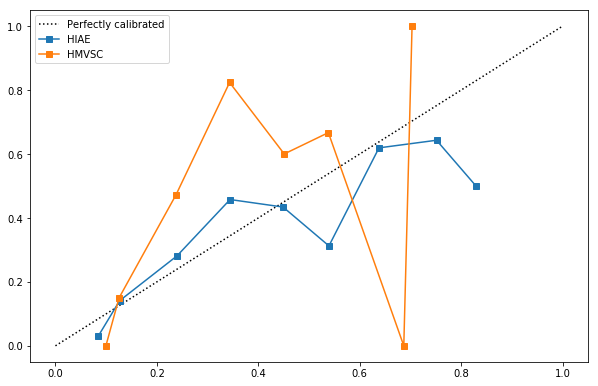

0.7339302297000584 SMR HIAE
1.2879657748738833 SMR HMVSC
0.8368794814619128 AUC HIAE
0.8335158107885381 AUC HMVSC
(0.1898103206509995, 0.20747376688843733) CI HIAE
(0.3056763334242534, 0.36048047160553853) CI HMVSC


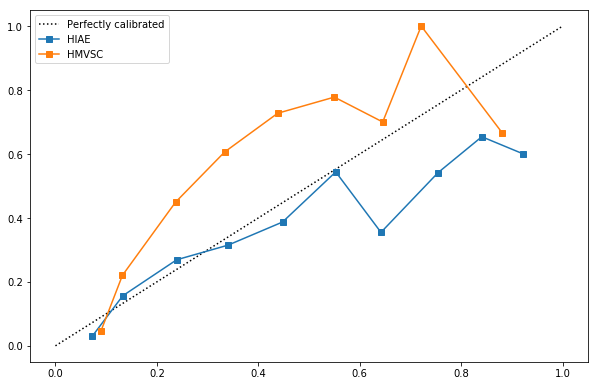

In [1658]:
'''Run the model on each of the four blocks'''
for block in range(1,5):    
    xgboost(hiae.copy(), hmvsc.copy(), columns(block), target)

## XGBoost trained in HIAE imputed data

In [1659]:
def xgboost_imp(hiae, hmvsc, columns, target):
    '''logistic regression helper function to be applied on each block'''
    
    #Get x and y values
    X_hiae = hiae[columns].copy()
    X_hmvsc = hmvsc[columns].copy()
    
    y_hiae = hiae[target].copy()
    y_hmvsc = hmvsc[target].copy()    
    
    # Create null flag column
    for c in X_hiae.columns:
        X_hiae[c+"_null"] = X_hiae[c].isna().astype(int)
        X_hmvsc[c+"_null"] = X_hmvsc[c].isna().astype(int)

    # Get unique values for categorical features after filtering the columns according to each block
    c_cols = [c for c in c_cols_og if c in X_hiae.columns]
    n_cols = [n for n in n_cols_og if n in X_hiae.columns]

    values = [(c, X_hiae.append(X_hmvsc).dropna()[c].unique()) for c in c_cols]

    # Model
    xgbi = XGBClassifier(n_estimators=100, max_depth=2)

    # Filter the normal according to the block
    filtered_normal = {}
    for key in normal.keys():
        if key in n_cols: filtered_normal[key] = normal[key]
    
    # Create pipeline
    pipe_xgbi = Pipeline([
        ("imputer", CustomImputer(filtered_normal, c_cols)),
        ("lenc", CustomLabelEncoder(values)),
        ("model", xgbi)
    ])
    
    predict_probs(pipe_xgbi, X_hiae, y_hiae, X_hmvsc, y_hmvsc)

0.7890050138547804 SMR HIAE
1.3082098203309254 SMR HMVSC
0.6768059709839362 AUC HIAE
0.6635498340043795 AUC HMVSC
(0.18324492527174494, 0.1980456962068645) CI HIAE
(0.306737434147519, 0.35491383094170026) CI HMVSC


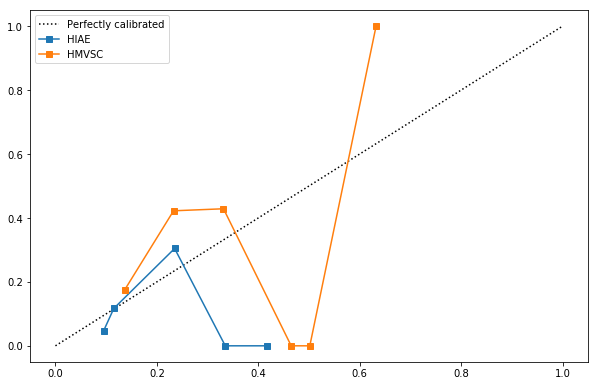

0.7466726035143461 SMR HIAE
1.3330028082029541 SMR HMVSC
0.7865082773365786 AUC HIAE
0.7330089943726308 AUC HMVSC
(0.18876375094089726, 0.20461022027920378) CI HIAE
(0.30359276826846204, 0.3527269691637078) CI HMVSC


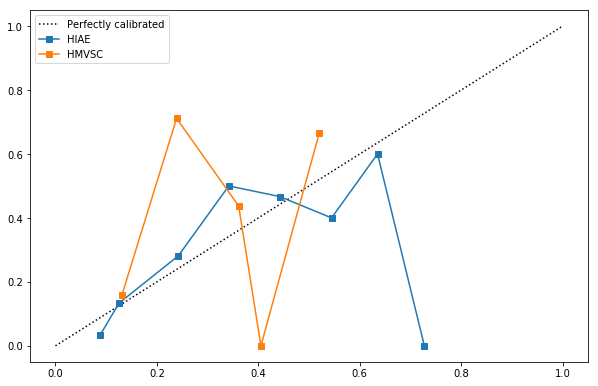

0.7254161287131924 SMR HIAE
1.3189618935126317 SMR HMVSC
0.8129841940369456 AUC HIAE
0.7678651315014952 AUC HMVSC
(0.19170033372226328, 0.2082729416774802) CI HIAE
(0.3044836128360763, 0.354830893780417) CI HMVSC


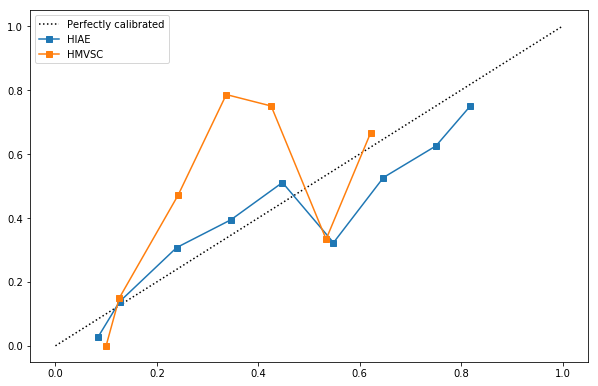

0.7211158945763099 SMR HIAE
1.298899634671162 SMR HMVSC
0.8374518649099941 AUC HIAE
0.833033128487674 AUC HMVSC
(0.1918482473998732, 0.20950739753864903) CI HIAE
(0.3050244417421682, 0.35868146746762036) CI HMVSC


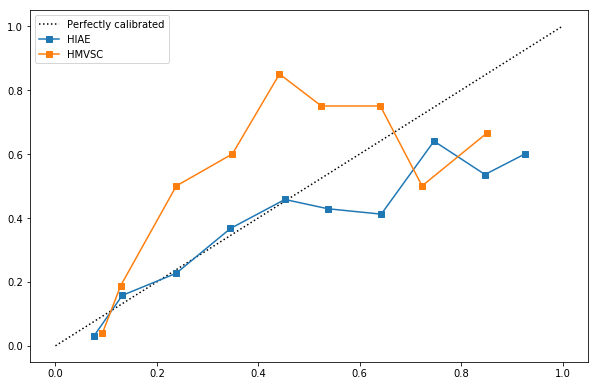

In [1660]:
'''Run the model on each of the four blocks'''
for block in range(1,5):    
    xgboost_imp(hiae.copy(), hmvsc.copy(), columns(block), target)